In [2]:
import os
import re
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
ETTm1 = pd.read_csv('../../dataset/ETT-small/ETTm1.csv')
ETTm2 = pd.read_csv('../../dataset/ETT-small/ETTm2.csv')
ETTh1 = pd.read_csv('../../dataset/ETT-small/ETTh1.csv')
ETTh2 = pd.read_csv('../../dataset/ETT-small/ETTh2.csv')

- 6 power load features

- target: oil temperature

In [16]:
ETTm1['date'] = pd.to_datetime(ETTm1['date'])
ETTm2['date'] = pd.to_datetime(ETTm2['date'])
ETTh1['date'] = pd.to_datetime(ETTh1['date'])
ETTh2['date'] = pd.to_datetime(ETTh2['date'])

In [4]:
ETTm1

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462,9.567000
69676,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567000
69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432,9.426000
69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523,9.426000


In [7]:
ETTh1

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [13]:
ETTm1['date']

0        2016-07-01 00:00:00
1        2016-07-01 00:15:00
2        2016-07-01 00:30:00
3        2016-07-01 00:45:00
4        2016-07-01 01:00:00
                ...         
69675    2018-06-26 18:45:00
69676    2018-06-26 19:00:00
69677    2018-06-26 19:15:00
69678    2018-06-26 19:30:00
69679    2018-06-26 19:45:00
Name: date, Length: 69680, dtype: object

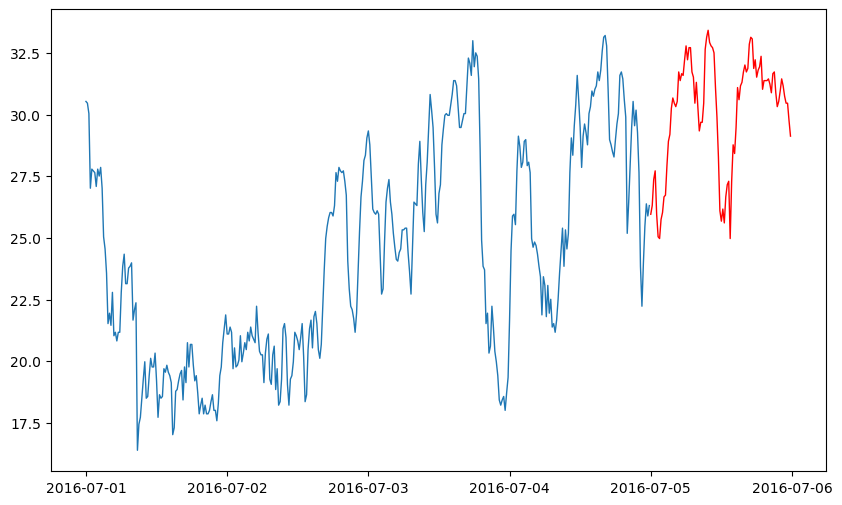

In [28]:
plt.figure(figsize=(10, 6))

start_idx = 0
seq_len = 24 * 4 * 4
pred_len = 24 * 4
lw = 1
plt.plot(ETTm1['date'][start_idx:start_idx+seq_len], ETTm1['OT'][start_idx:start_idx+seq_len], linewidth=lw)
plt.plot(ETTm1['date'][start_idx+seq_len:start_idx+seq_len + pred_len], ETTm1['OT'][start_idx+seq_len:start_idx+seq_len + pred_len], linewidth=lw, color='r')

plt.show()

In [73]:
import os
import numpy as np
import pandas as pd
import glob
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
# from utils.timefeatures import time_features
# from data_provider.m4 import M4Dataset, M4Meta
# from data_provider.uea import subsample, interpolate_missing, Normalizer
from sktime.datasets import load_from_tsfile_to_dataframe
import warnings
# from utils.augmentation import run_augmentation_single

warnings.filterwarnings('ignore')

class Dataset_ETT_minute(Dataset):
    def __init__(self, args, root_path, flag='train', size=None,
                 features='M', data_path='ETTm1.csv',
                 target='OT', scale=True, 
                 timeenc=0, freq='t'):
        """ETTm1 dataset, one point per 15 minutes.

        Parameters
        ----------
        args (_type_): _description_
        
        root_path : str,  Root directory of data.
        
        flag : str, optional, default='train'.
            data type, 'train', 'val', or 'test'
        
        size : Tuple[int, int, int] or None, default=None.
            seq_len, label_len, pred_len, 
            if None, use predefined in [24*4*4, 24*4, 24*4]
            
        features: str, default='M', options:[M, S, MS].
            M: multivariate predict multivariate, 
            S: univariate predict univariate, 
            MS: multivariate predict univariate.
            
        data_path: str, optional, default='ETTm1.csv'.
        
        target: str, default='OT'.
            The predict value "oil temperature".
        
        scale : bool, default=True.
            Whether to scale data with StandardScaler.
        
        timeenc : int, optional, default=0.
            0: time features, include mounth, day, weekday, hour, minute,
            1: apply time_features function.
            
        freq : str, optional, default='t'.
            freq for time features encoding, options:[
            s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, 
            m:monthly], you can also use more detailed freq like 15min or 3h.
            
        Return
        ----------
        Tuple of Tensor: (seq_x, seq_y, seq_x_mark, seq_y_mark)
        seq_x: 
        seq_y: 
        seq_x_mark: 
        seq_y_mark:  
        
        """
        # size [seq_len, label_len, pred_len]
        self.args = args
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        # split train, val, test
        # border1s: [0, 34176, 45696], 
        # border2s: [34560, 46080, 57600]
        border1s = [0, 12 * 30 * 24 * 4 - self.seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - self.seq_len]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]
        print(f"border1s: {border1s}, border2s: {border2s}")
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        # forecasting task
        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]  # except date
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]  # only target
            
        # data scale
        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        # time features: mounth, day, weekday, hour, minute
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)  # [0, 15, 30, 45] -> [0, 1, 2, 3]
            data_stamp = df_stamp.drop(['date'], axis=1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]

        # data augmentation
        if self.set_type == 0 and self.args.augmentation_ratio > 0:
            self.data_x, self.data_y, augmentation_tags = run_augmentation_single(self.data_x, self.data_y, self.args)

        self.data_stamp = data_stamp

    def __getitem__(self, index):
        """
        |------|----------seq_y-----------|
        |------|--label_len--|--pred_len--|
        |---------------------------------|
        |-------seq_len------|
        |-------seq_x--------|
        """
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

In [74]:
import argparse
args = argparse.Namespace(augmentation_ratio=0)
root_path = '../../dataset/ETT-small/'
dataset = Dataset_ETT_minute(args, root_path)

border1s: [0, 34176, 45696], border2s: [34560, 46080, 57600]
cols_data: Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


In [78]:
len(dataset), dataset[0][0].shape, dataset[0][1].shape

(34081, (384, 7), (192, 7))

In [75]:
dataset[0][0].shape

(384, 7)

In [77]:
dataset[0][1].shape

(192, 7)

In [71]:
ETTm1

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462,9.567000
69676,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567000
69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432,9.426000
69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523,9.426000
